In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

In [4]:
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Loading and Basic Data Understanding

### Loading Dataset

In [6]:
boombikes = pd.read_csv('day.csv')
boombikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.11085,18.18125,80.58330,10.74988,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.90260,17.68695,69.60870,16.65211,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.05092,9.47025,43.72730,16.63670,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.20000,10.60610,59.04350,10.73983,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.30524,11.46350,43.69570,12.52230,82,1518,1600


### Basic Observations and Data Understanding

In [7]:
print(f'Given dataset contains {boombikes.shape[0]} rows and {boombikes.shape[1]} columns.')

Given dataset contains 730 rows and 16 columns.


In [8]:
boombikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


##### Observations:
- Dataset contains 730 rows
- Dataset contains 16 columns
- **Dataset does not contain null values. Hence null value handling will not be done as a part of this assignment**

In [9]:
# Checking for duplicate values
len(boombikes[boombikes.duplicated()])

0

No duplicate values found

### Feature Understanding

**Following information about various columns has been extracted from data dictionary. Columns furthur understanding is hilighted by the research wherever an explanation is needed**

- instant: record index. `This column acts as a serial number and is thus redundant. It will be dropped in the next step.`
- dteday: date. `Since purpose of this assignment is aimed at Linear Regression, and we have been given the day of the week, month, year, holiday data in separate column, we will drop this column in the next step too.`
- season: season(1-Spring, 2-Summer, 3-Fall, 4-Winter) `This feature will be converted to season names so that proper dummies can be created`
- yr: year(0-2018, 1-2019) `This column signifies the year in boolean form as indicated.`
- mnth: month(1 to 12) `This feature will be converted to month names so that proper dummies can be created.`
- holiday: Weather the day is a holiday or not. `This is a binary variable.`
- weekday: day of the week `This feature will be converted to day names so that proper dummies can be created.`
- workingday: if day is neither weekend nor holiday then 1, otherwise 0. `This variable is an extract of holiday and weekday. During the course of assignment, post visualization, researcher will decide on transforming this column further if required.`
- weathersit: `Numeric values in this column will be converted to below mentioned text entries. Post conversion, patterns will be visualized and dummy variables will be created before the model development.`
    - 1: Clear to Partly Cloudy
    - 2: Misty and Cloudy
    - 3: Light Rain and Light Snow
    - 4: Heavy Rain and Heavy Snow
- temp: Temperature in celsius
- atemp: Feeling temperature in celsius
- hum: Humidity
- windspeed: wind speed
- casual: Unregistered customers
- registered: Count of registered users
- cnt: Coun including both casual and registered. `This is the Target Variable. Since this column is sum of casual and registered, ideally we should drop both the variables. However we will decide on dropping them at later stage post visualisation`

### Dropping features based on above shared logic

In [10]:
# Creating variable to store list of feature names to be dropped
drop_columns = ['instant', 'dteday']

# Creating a loop to drop the columns
for i in boombikes.columns:
    if i in drop_columns:
        boombikes.drop(labels= i, axis= 1, inplace= True)

# Inspecting dataframe
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.11085,18.18125,80.58330,10.74988,331,654,985
1,1,0,1,0,0,0,2,14.90260,17.68695,69.60870,16.65211,131,670,801
2,1,0,1,0,1,1,1,8.05092,9.47025,43.72730,16.63670,120,1229,1349
3,1,0,1,0,2,1,1,8.20000,10.60610,59.04350,10.73983,108,1454,1562
4,1,0,1,0,3,1,1,9.30524,11.46350,43.69570,12.52230,82,1518,1600


### Basic Data Propriety Assessment

In [11]:
boombikes.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000,730.00000
mean,2.49863,0.50000,6.52603,0.02877,2.99726,0.68356,1.39452,20.31926,23.72632,62.76517,12.76362,849.24932,3658.75753,4508.00685
std,1.11018,0.50034,3.45022,0.16727,2.00616,0.46541,0.54481,7.50673,8.15031,14.23759,5.19584,686.47987,1559.75873,1936.01165
min,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,2.42435,3.95348,0.00000,1.50024,2.00000,20.00000,22.00000
25%,2.00000,0.00000,4.00000,0.00000,1.00000,0.00000,1.00000,13.81189,16.88971,52.00000,9.04165,316.25000,2502.25000,3169.75000
50%,3.00000,0.50000,7.00000,0.00000,3.00000,1.00000,1.00000,20.46583,24.36822,62.62500,12.12533,717.00000,3664.50000,4548.50000
75%,3.00000,1.00000,10.00000,0.00000,5.00000,1.00000,2.00000,26.88061,30.44577,72.98958,15.62559,1096.50000,4783.25000,5966.00000
max,4.00000,1.00000,12.00000,1.00000,6.00000,1.00000,3.00000,35.32835,42.04480,97.25000,34.00002,3410.00000,6946.00000,8714.00000


##### Observations:
- **season:** Season column has 4 values depicting each of the 4 seasons. No deviation found.
- **yr:** Data comprises of exactly 2 years.
- **mnth:** Number of months is exactly 12, hence no abnormalities noticed.
- **holiday:** Max is 1 and Min is 0. No deviations in this binary column.
- **weekday:** Weekdays are depicted as exactly 7 (0 to 6) corresponding to each day name. On checking data, it was noticed that the numerical values start from 0 on Tuesday.
- **weathersit:** As per data dictionary, we are suppose to have 4 weather situations whereas the data does not contain the 4th weather. The value corresponds to weather situation 1 OR 2 OR 3 only.
- **temp:** The variance of temperature is between 2.4 to 35.3 with median value of 20.4. This is indicative of Tropical Climate in the region. This could to a certain extent, possibly explain the absesnce of fourth season.
- **hum:** Humidity level for both Q1 and Q3 are more than 50% which shows that the place has relatively humid weather.
- **windspeed:** Wind speed does not have heavy variance. Relatively calmer winds.
- **casual:** Relatively high variance as compared to 'registered'
- **registered:** With given numbers, it seems to be more in line with the trend on target variable (cnt)

### Transfoming season, weathersit, mnth, and weekday columns based on above logic

In [12]:
# Transforming weathersit feature:
boombikes['weathersit'] = boombikes['weathersit'].map({ 1: 'Clear to Partly Cloudy', 2: 'Misty and Cloudy',
                                                      3: 'Light Rain or Snow', 4: 'Heavy Rain or Snow'})

# Transforming season feature:
boombikes['season'] = boombikes['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

# Mapping month feature:
boombikes['mnth'] = boombikes['mnth'].map({
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
})

# Mapping weekday feature:
boombikes['weekday'] = boombikes['weekday'].map({
    0: 'Tue',
    1: 'Wed',
    2: 'Thu',
    3: 'Fri',
    4: 'Sat',
    5: 'Sun',
    6: 'Mon'
})

boombikes['workingday'] = boombikes['workingday'].shift(-2)

# Find the index of the last row
last_index = len(boombikes) - 1

# Fill the last two cells of the specified column with ones
boombikes['workingday'].iloc[last_index - 1:last_index + 1] = 1

boombikes['workingday'] = boombikes['workingday'].astype(int)

# Observe the dataset
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,Spring,0,Jan,0,Mon,1,Misty and Cloudy,14.11085,18.18125,80.58330,10.74988,331,654,985
1,Spring,0,Jan,0,Tue,1,Misty and Cloudy,14.90260,17.68695,69.60870,16.65211,131,670,801
2,Spring,0,Jan,0,Wed,1,Clear to Partly Cloudy,8.05092,9.47025,43.72730,16.63670,120,1229,1349
3,Spring,0,Jan,0,Thu,1,Clear to Partly Cloudy,8.20000,10.60610,59.04350,10.73983,108,1454,1562
4,Spring,0,Jan,0,Fri,1,Clear to Partly Cloudy,9.30524,11.46350,43.69570,12.52230,82,1518,1600


# Exploratory Data Analysis

## Univariate Analysis

### Target Variable

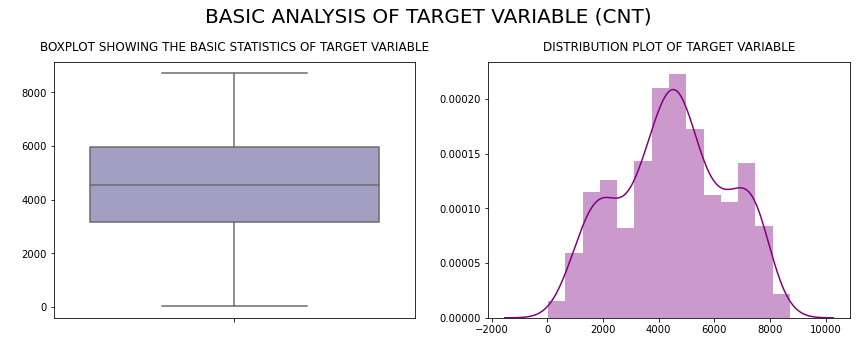

In [14]:
# Creating a subplot grid
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(12, 5))

# Creating main title
fig.suptitle('basic analysis of target variable (cnt)'.upper(), fontsize=20)

# Populating plot1:
sns.boxplot(y= boombikes['cnt'], ax= ax[0], palette= 'Purples')
ax[0].set_title('boxplot showing the basic statistics of target variable'.upper(), fontsize= 12, fontweight= 20, y= 1.02)
ax[0].set_ylabel(' ')
ax[0].set_xlabel(' ')

# Populating plot1:
sns.distplot(boombikes['cnt'], ax= ax[1], color= 'purple')
ax[1].set_title('distribution plot of target variable'.upper(), fontsize= 12, fontweight= 20, y= 1.02)
ax[1].set_ylabel(' ')
ax[1].set_xlabel(' ')

# Setting aesthetics
plt.tight_layout()
plt.show()

#### Observations:
- Target variable shows an almost normal distribution of values with 2 distinct plateaus on either side.
- Q1 of target variable lies at around 3000 and Q3 at around 6000. IQR thus is approximately 3000 with median at around 4500.

### Continuous Independent Variables

In [15]:
# Creating a list of continuous independent variables for analysis
continuous_vars = [i for i in boombikes.select_dtypes(exclude= 'object').columns if boombikes[i].nunique() > 2 and i != 'cnt']

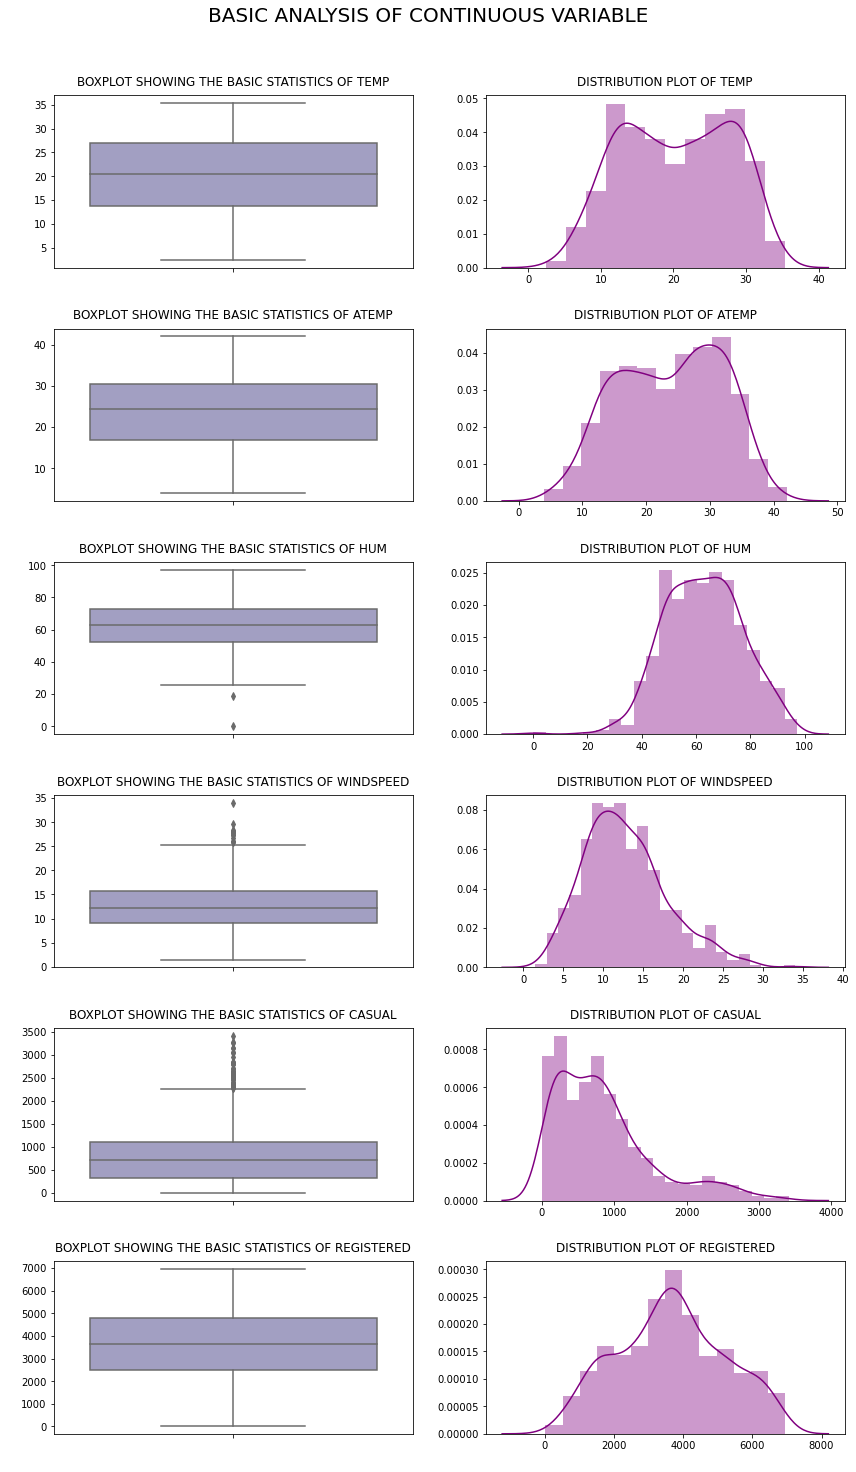

In [49]:
# Creating a subplot grid
fig, ax = plt.subplots(nrows= len(continuous_vars), ncols= 2, figsize=(12, 20))

# Creating main title
fig.suptitle('basic analysis of continuous variable'.upper(), fontsize=20, y=1.02)

# Looping to fill subplot grid with plots
for i in range(len(continuous_vars)):
    sns.boxplot(y= boombikes[continuous_vars[i]], ax= ax[i, 0], palette = 'Purples')
    
    # Setting aesthetics and readability
    ax[i, 0].set_title(f'boxplot showing the basic statistics of {continuous_vars[i]}'.upper(), fontsize= 12, fontweight= 20, y= 1.02)
    ax[i, 0].set_ylabel(' ')
    ax[i, 0].set_xlabel(' ')
    
    sns.distplot(boombikes[continuous_vars[i]], ax= ax[i, 1], color= 'purple')
    ax[i, 1].set_title(f'distribution plot of {continuous_vars[i]}'.upper(), fontsize= 12, fontweight= 20, y= 1.02)
    ax[i, 1].set_ylabel(' ')
    ax[i, 1].set_xlabel(' ')

# Setting final aesthetics
plt.tight_layout()
plt.show()

#### Observations:
- Q1 and Q3 of temp is distributed between 14 and 27 with median as 21.
- Q1 and Q3 of atemp is distributed between 17 and 31 with median as 24.
- Humidity, Windspeed, and Casual have shown some presence of outliers.
- Temp and Atemp appear to be almost normally distributed.
- Temp and ATemp have shown double peaks.
- Humidity and Windspeed are left and right skewed respectively.
- Casual shows right hand skewed.
- Registered shows similar trend as target variable but plateaus on both side are relatively smoother.

### Categorical Independent Variables

In [34]:
# Creating a list of categorical independent variables for analysis
categorical_vars = [i for i in boombikes.select_dtypes(include= 'object').columns]
categorical_vars.extend([i for i in boombikes.columns if boombikes[i].nunique() == 2])

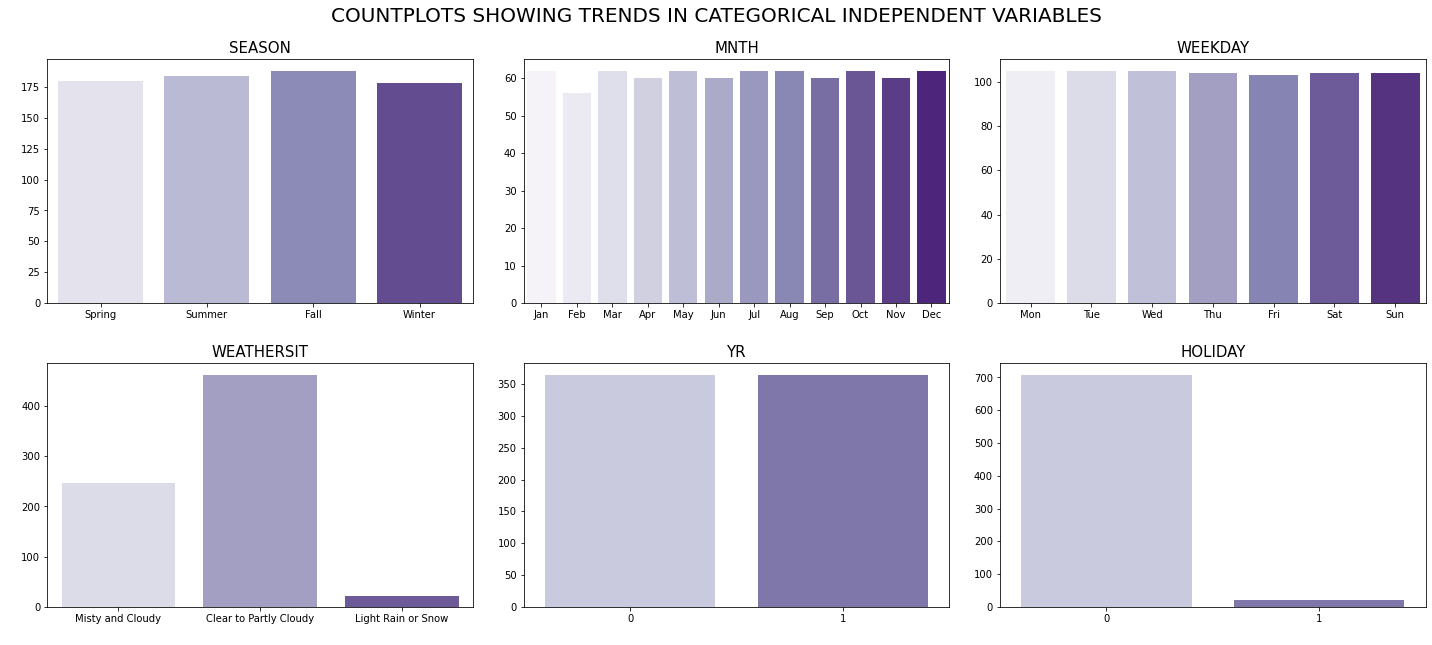

In [45]:
# Creating a subplot grid
fig, ax = plt.subplots(nrows= 2, ncols= int(len(categorical_vars)/2), figsize=(20, 9))

# Placing main title
plt.suptitle('countplots showing trends in categorical independent variables'.upper(), fontsize= 20, fontweight= 20, y= 0.99)

# Looping to fill subplot grid with plots
k= 0
for i in range(2):
    for j in range(int(len(categorical_vars)/2)):
        sns.countplot(x= categorical_vars[k], data= boombikes, ax= ax[i, j], palette= 'Purples')
        
        # Setting aesthetics and readability
        ax[i, j].set_title(f'{categorical_vars[k].upper()}', fontsize= 15)
        ax[i, j].set_ylabel(' ')
        ax[i, j].set_xlabel(' ')
        
        k+=1

# Setting final aesthetics
plt.tight_layout()
plt.show()



#### Observations:
- Fall is found to be the longest season, followed by summer, and spring. Shortest season is winter.
- Weathersit shows just 3 types of weathers. There is not even a single day on which heavy rain/snow has occured. Weather has been clear or partly cloudy for most of the days in both years.

## Bivariate Analysis

### Continuous Independent Variables

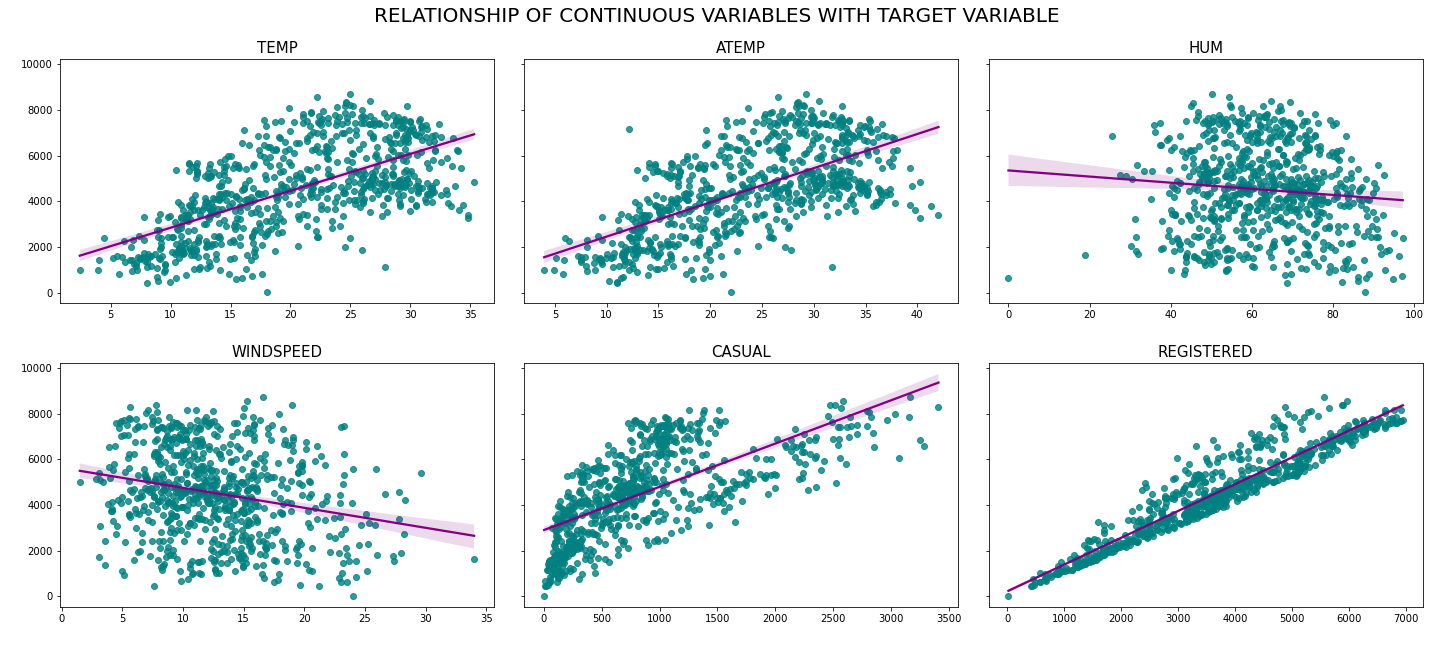

In [56]:
# Creating a subplot grid
fig, ax = plt.subplots(nrows= 2, ncols= int(len(continuous_vars)/2), figsize=(20, 9), sharey= True)

# Placing main title
plt.suptitle('relationship of continuous variables with target variable'.upper(), fontsize= 20, fontweight= 20, y= 0.99)

# Looping to fill subplot grid with plots
k= 0
for i in range(2):
    for j in range(int(len(continuous_vars)/2)):
        sns.regplot(x= boombikes[continuous_vars[k]], y= boombikes['cnt'], ax= ax[i, j], scatter_kws= {'color': 'teal'}, line_kws= {'color': 'purple'})
        
        # Setting aesthetics and readability
        ax[i, j].set_title(f'{continuous_vars[k].upper()}', fontsize= 15)
        ax[i, j].set_ylabel(' ')
        ax[i, j].set_xlabel(' ')
        
        k+=1

# Setting final aesthetics
plt.tight_layout()
plt.show()



#### Observations:
- Bike demand shows a similar and directly proportional with temp and atemp.
- Bike demand shows an inversely proportional with Humidity and Windspeed.
- Bike demand is directly proportional with casual and registered users.
- Bike demand is very well explained by the registered users.

### Continuous Independent Variables

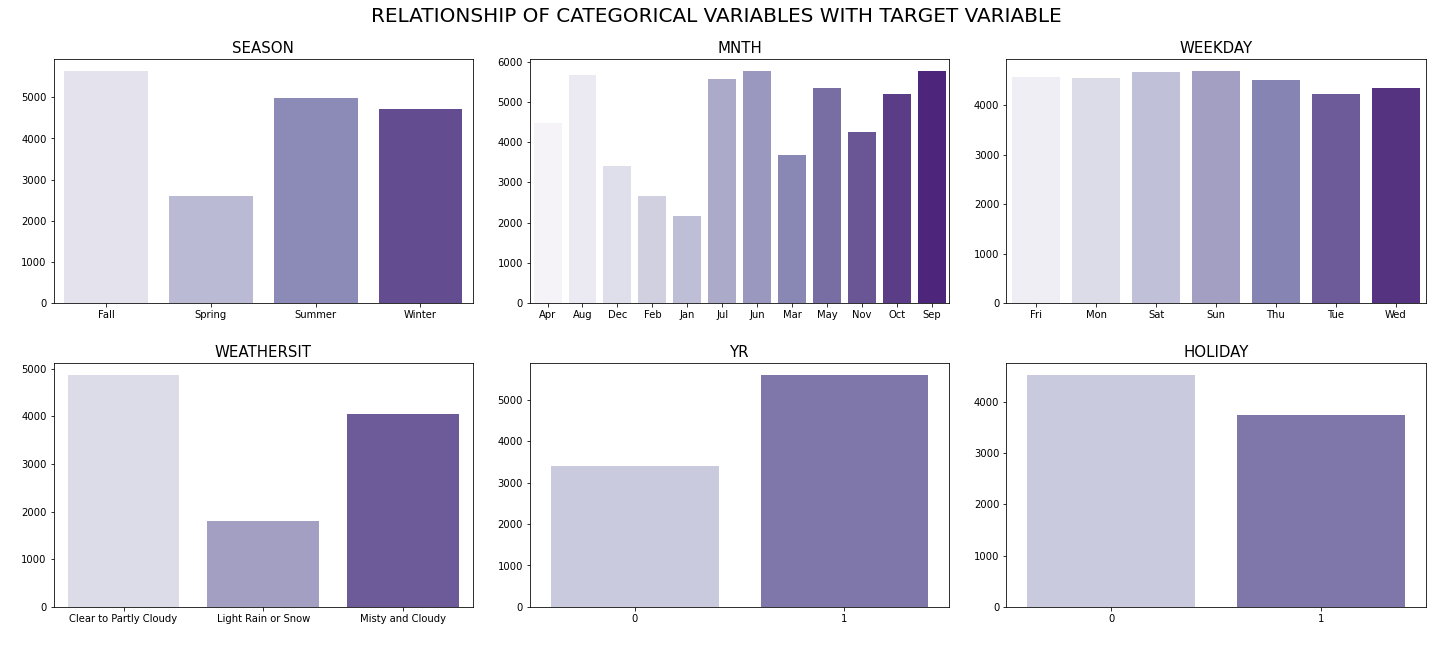

In [58]:
# Creating a subplot grid
fig, ax = plt.subplots(nrows= 2, ncols= int(len(categorical_vars)/2), figsize=(20, 9))

# Placing main title
plt.suptitle('relationship of categorical variables with target variable'.upper(), fontsize= 20, fontweight= 20, y= 0.99)

# Looping to fill subplot grid with plots
k= 0
for i in range(2):
    for j in range(int(len(categorical_vars)/2)):
        sns.barplot(
            y= boombikes.groupby(by= categorical_vars[k]).mean()['cnt'],
            x= boombikes.groupby(by= categorical_vars[k]).mean().index,
            ax= ax[i, j],
            palette = 'Purples'
        )
        
        # Setting aesthetics and readability
        ax[i, j].set_title(f'{categorical_vars[k].upper()}', fontsize= 15)
        ax[i, j].set_ylabel(' ')
        ax[i, j].set_xlabel(' ')
        
        k+=1

# Setting final aesthetics
plt.tight_layout()
plt.show()



#### Observations:
- Maximum demand noticed in Fall Season followed by Summer, and Winter. Spring season shows a steep decrease in demand.
- Months of August, June, and September display highest demand trend followed by the month of July, May, and October. `This effectively defines a six months period from May till October as high demand period. Months seems to show drastic impact on business.`
- Highest demand traction observed on Friday, Saturday, Sunday, and Thursday. `This effectively shows that the usage of bikes have been for mixed use (For office as well as leisure travels).`
- Demand is exceptionally high on clear days.
- Demand of bikes on holidays is slightly lower than weekdays.

### Demand comparison on Working Day and Non Working Day

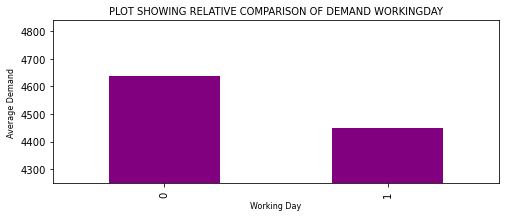

In [59]:
plt.figure(figsize= (8,3))
plt.title('plot showing relative comparison of demand workingday'.upper(), fontsize= 10)
boombikes.groupby(by= 'workingday').mean()['cnt'].plot.bar(color= 'purple')
plt.ylabel('average demand'.title(), fontsize= 8)
plt.xlabel('working day'.title(), fontsize= 8)
plt.ylim(min(boombikes.groupby(by= 'workingday').mean()['cnt'])-200,
         max(boombikes.groupby(by= 'workingday').mean()['cnt'])+200
        )
plt.show()

#### Observations:
- Usage is found to be higer on non-working days.

### Seasonwise variation in weather related continuous variables

In [60]:
# Initializing feature list for weather related continuous variables:
weather_vars = ['temp', 'atemp', 'hum', 'windspeed']

In [65]:
def variationby(by, analysis_for, analyzing):
    # Creating a subplot grid
    fig, ax = plt.subplots(nrows= 1, ncols= len(weather_vars), figsize=(20, 5))

    # Placing main title
    plt.suptitle(f'analyzing {analyzing} variation in weather related continuous variables'.upper(), fontsize= 20, fontweight= 20, y= 0.99)

    # Looping to fill subplot grid with plots
    for i in range(len(analysis_for)):
        sns.barplot(
            y= boombikes.groupby(by= by).mean()[analysis_for[i]],
            x= boombikes.groupby(by= by).mean().index,
            ax= ax[i],
            palette = 'Purples'
        )

        # Setting aesthetics and readability
        ax[i].set_title(f'{analysis_for[i].upper()}', fontsize= 15)
        ax[i].set_ylabel(' ')
        ax[i].set_xlabel(' ')

    # Setting final aesthetics
    plt.tight_layout()
    plt.show()

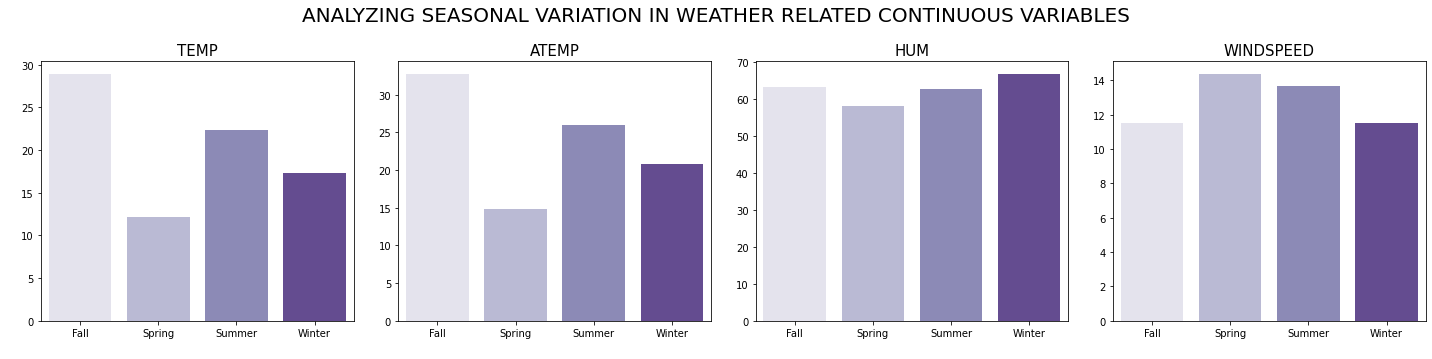

In [68]:
variationby(by= 'season', analysis_for= weather_vars, analyzing= 'seasonal')

#### Observations:
- Weather variables have shown an unusual pattern wherein the average temperature and average temperature feeling is found to be highest in fall season followed by summer.
- Instead of winters, spring shows relatively lower average temperature and average temperature feeling.
- Humidity is found to be highest in winter followed by fall, summer, and spring.
- Windspeed is found to be highest in spring followed by summer.

### Reference Table that shows seasonwise and monthwise variation of continuous weather features

In [64]:
boombikes.groupby(by= ['season', 'mnth']).mean()

yr  holiday  workingday     temp    atemp      hum  \
season mnth                                                           
Fall   Aug  0.50000  0.00000     0.70968 29.05184 32.57374 63.77301   
       Jul  0.50000  0.03226     0.69355 30.97429 35.20469 59.78763   
       Jun  0.50000  0.00000     0.65000 29.81554 33.56743 54.40625   
       Sep  0.50000  0.04545     0.65909 25.59775 29.35985 71.83132   
Spring Dec  0.50000  0.09091     0.54545 12.21599 14.72987 63.84248   
       Feb  0.50000  0.03571     0.67857 12.23525 14.94305 56.32269   
       Jan  0.50000  0.04839     0.70968  9.69420 11.98979 58.58283   
       Mar  0.50000  0.00000     0.70000 16.01250 19.13531 56.98311   
Summer Apr  0.50000  0.03333     0.68333 19.26995 22.85404 58.80631   
       Jun  0.50000  0.00000     0.72500 27.16421 31.08471 59.16770   
       Mar  0.50000  0.00000     0.68182 16.01134 19.02927 62.23732   
       May  0.50000  0.03226     0.69355 24.38674 28.28310 68.89583   
Winter Dec  0.50000  0.00000     0.72500 13.87337 17.17595 68.12292   
       Nov  0.50000  0.06667     0.63333 15.13801 18.36794 62.48765   
       Oct  0.50000  0.03226     0.70968 19.88550 23.59866 69.37609   
       Sep  0.50000  0.00000     0.68750 24.39074 27.87898 70.48177   

             windspeed     casual  registered        cnt  
season mnth                                               
Fall   Aug    11.58552 1161.91935  4502.50000 5664.41935  
       Jul    11.12594 1260.59677  4303.08065 5563.67742  
       Jun    12.90432 1188.05000  4581.35000 5769.40000  
       Sep    11.39800 1184.86364  4487.84091 5672.70455  
Spring Dec    14.30449  293.77273  1660.68182 1954.45455  
       Feb    14.49457  266.03571  2403.92857 2669.96429  
       Jan    13.82229  194.22581  1982.11290 2176.33871  
       Mar    15.15784  678.85000  2872.77500 3551.62500  
Summer Apr    15.71031 1013.36667  3471.53333 4484.90000  
       Jun    12.18254 1253.62500  4520.22500 5773.85000  
       Mar    14.48999  785.90909  3162.04545 3947.95455  
       May    12.26026 1214.27419  4135.50000 5349.77419  
Winter Dec    10.47337  380.75000  3820.20000 4200.95000  
       Nov    12.31470  610.05000  3637.13333 4247.18333  
       Oct    11.73877  963.87097  4235.35484 5199.22581  
       Sep    10.34921 1136.81250  4887.68750 6024.50000

### Weathersit variation in weather related continuous variables

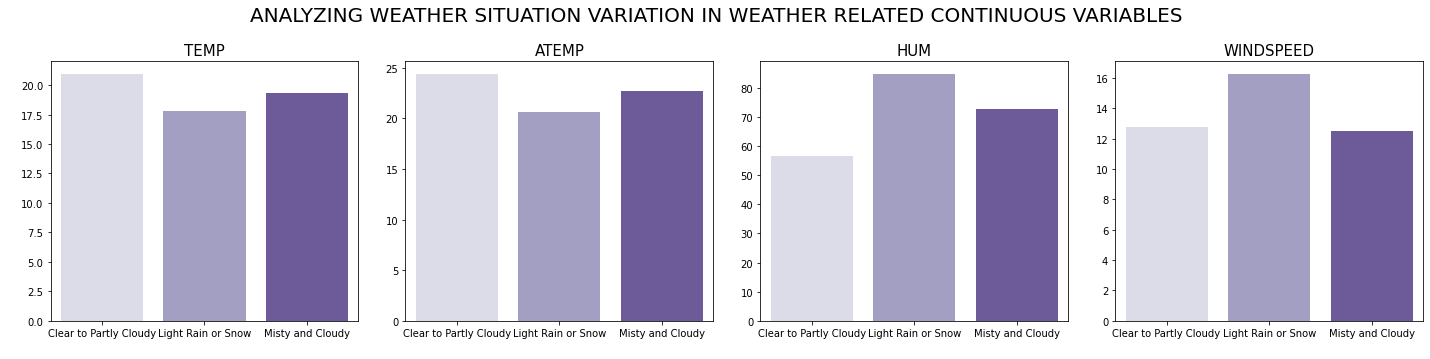

In [69]:
variationby(by= 'weathersit', analysis_for= weather_vars, analyzing= 'weather situation')

#### Observations:
- Temp and ATemp show highest mean values when the skies are clear to partly cloudy followed by misty weather, and light rain.
- Humididty is found to have highest mean values during light rain followed by misty weather followed by clea skies.
- Windspeed has highest mean value during light rains.

### Monthwise variation in Weather Situation

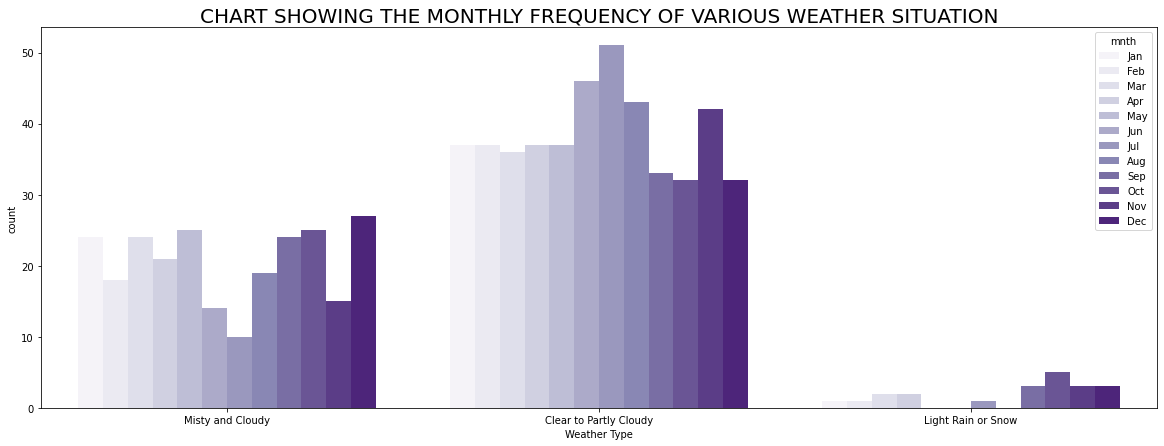

In [77]:
# Defining figure size
plt.figure(figsize= (20, 7))

# Plotting
sns.countplot('weathersit', data= boombikes, hue= 'mnth', palette = 'Purples')

# Adjusting labels and titles
plt.title('chart showing the monthly frequency of various weather situation'.upper(), fontsize= 20)
plt.xlabel('weather type'.title())

plt.show()

#### Observations:
- Overall, maximum number of days have been 'Clear to Partly Cloudy' followed by 'Misty and Cloudy'
- July has shown the maximum occurence of clear to partly cloudy days followed by June and then august.
- Maximum number of misty occurences have been observed in the month of december followed by January, March, May, and October.

## Intervariable Relationships

### Intervariable Relationships using pairplot

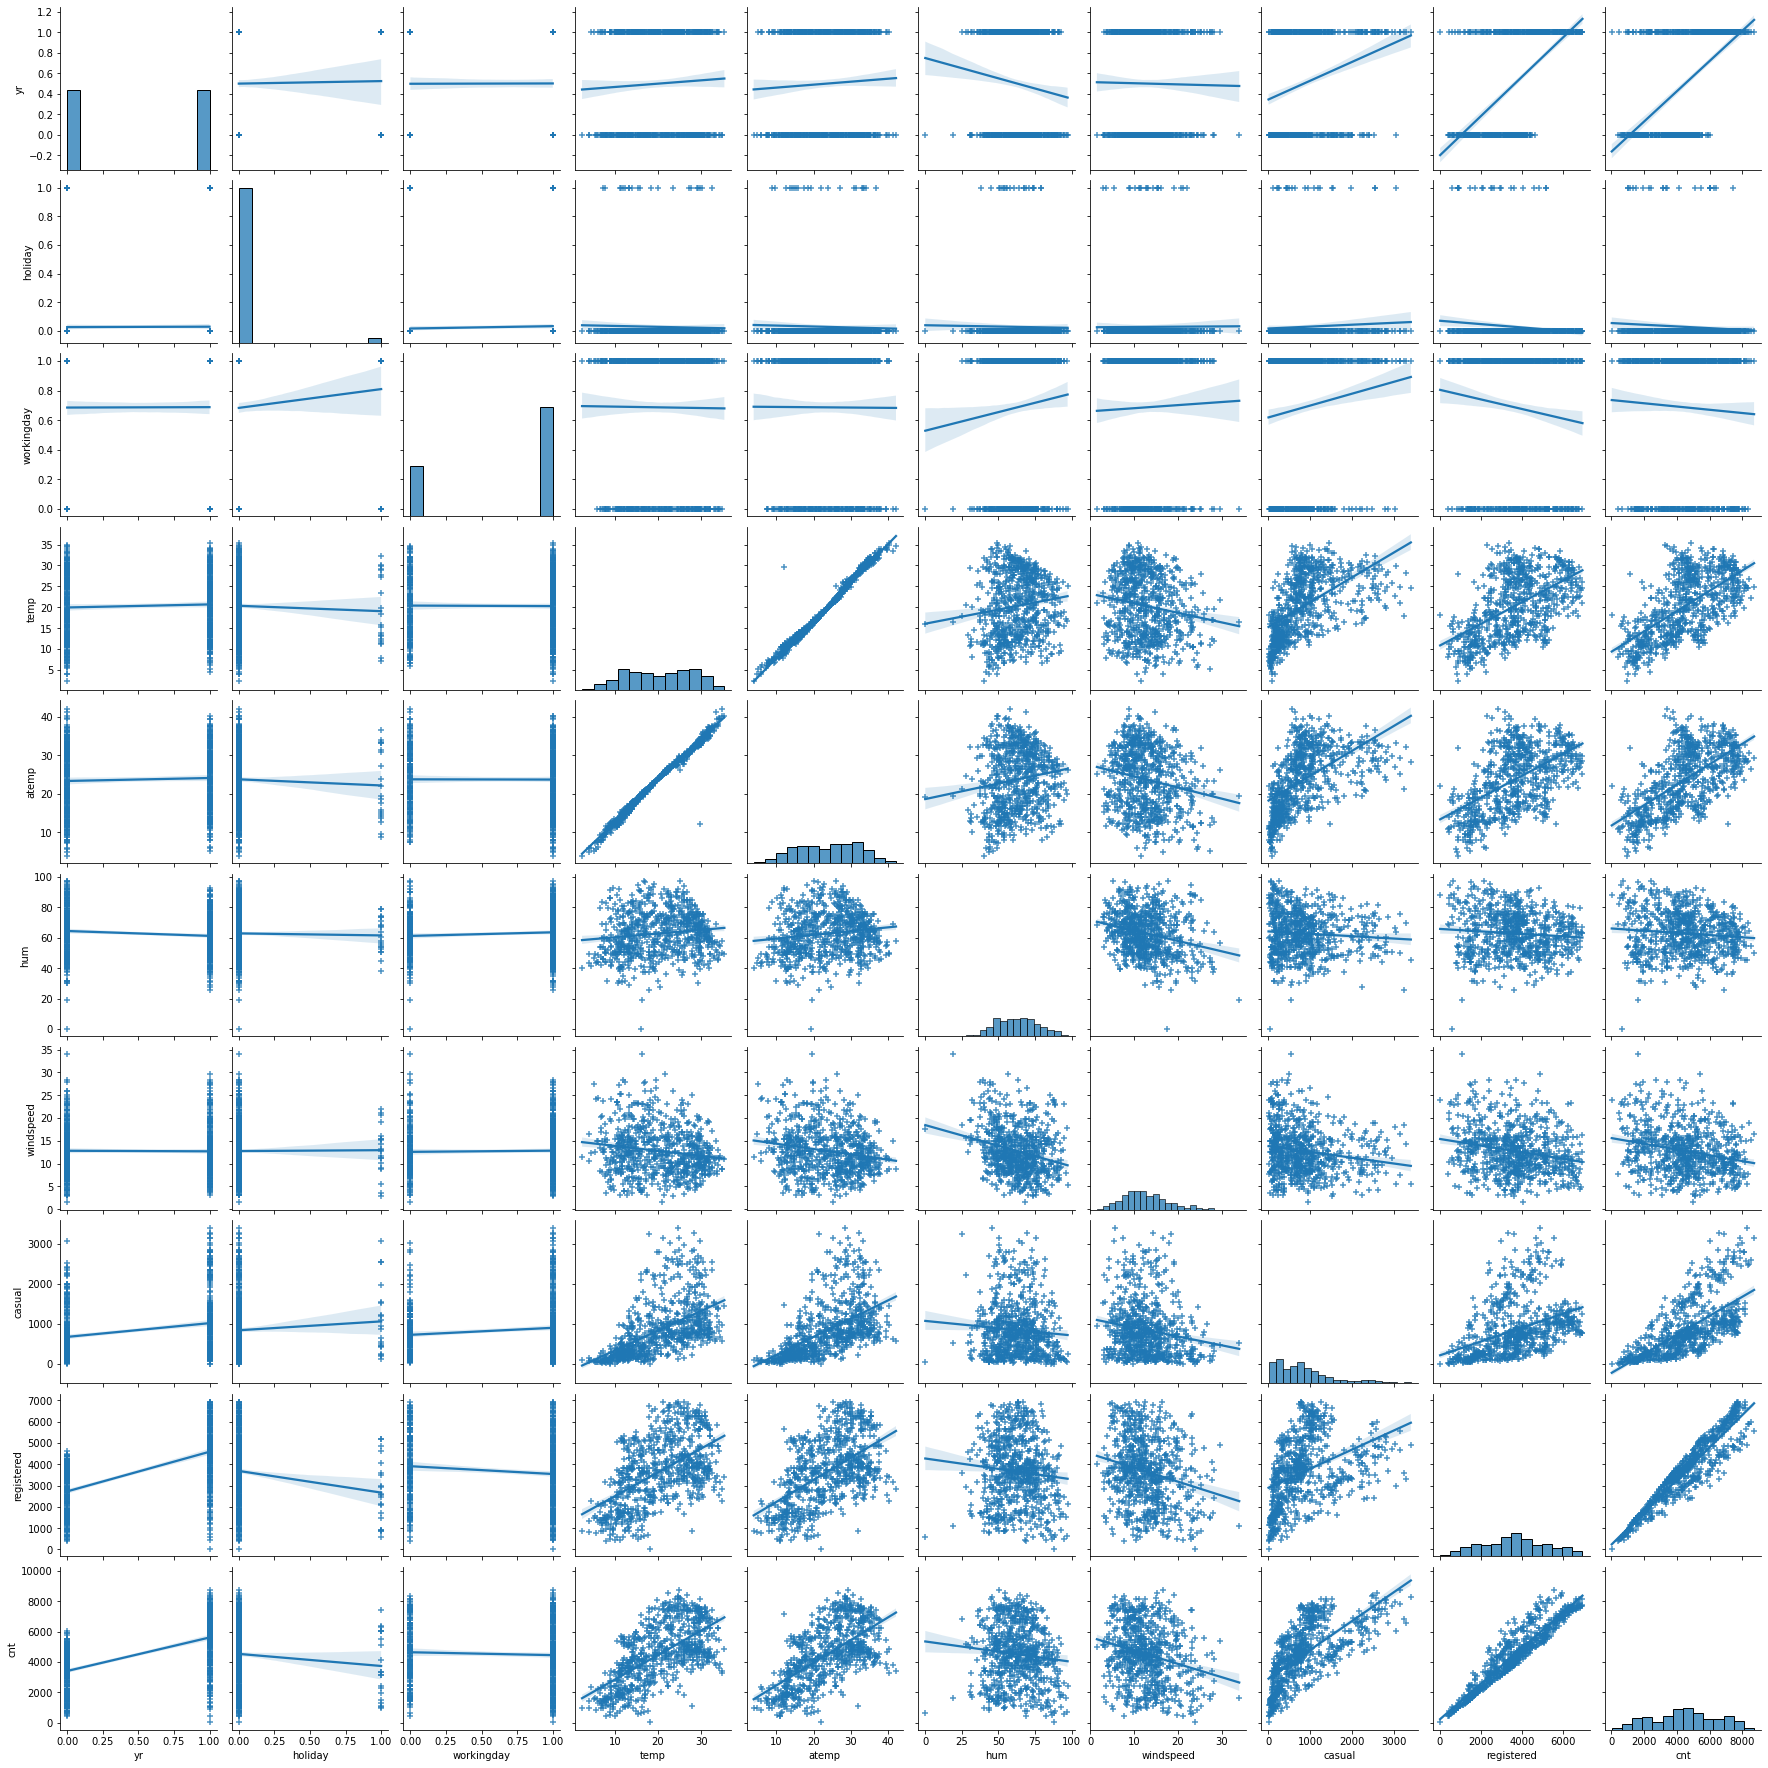

In [74]:
sns.pairplot(boombikes, kind= 'reg', markers= '+', palette= 'Purples')
plt.show()

#### Observations:
- Target Variable:
    - Directly proportional to temp, atemp, casual, and registered
    - Inversely proportional to humidity and windspeed

- Independent Variables
    - registered is directly proportional to temp, atemp, casual and inversely proportional to hum and windspeed
    - casual is directly proportional to temp, atemp, registered and inversely proportional to hum and windspeed
    - windspeed to inversely proportional to temp, atemp, and hum
    - humidity is directly proportional to temp, atemp and inversely proportional to windspeed

### NOTE
- Our target variable is a summation of 'casual' and 'registered'
- Based on above logic, features 'casual' and 'registered' can completly explain the target variable
- **Hence, dropping casual and registered features**

In [75]:
boombikes.drop(labels= ['casual', 'registered'], axis= 1, inplace= True)

In [76]:
# Re-inspecting dataframe
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,Jan,0,Mon,1,Misty and Cloudy,14.11085,18.18125,80.58330,10.74988,985
1,Spring,0,Jan,0,Tue,1,Misty and Cloudy,14.90260,17.68695,69.60870,16.65211,801
2,Spring,0,Jan,0,Wed,1,Clear to Partly Cloudy,8.05092,9.47025,43.72730,16.63670,1349
3,Spring,0,Jan,0,Thu,1,Clear to Partly Cloudy,8.20000,10.60610,59.04350,10.73983,1562
4,Spring,0,Jan,0,Fri,1,Clear to Partly Cloudy,9.30524,11.46350,43.69570,12.52230,1600


### Intervariable Relationships using heatmap

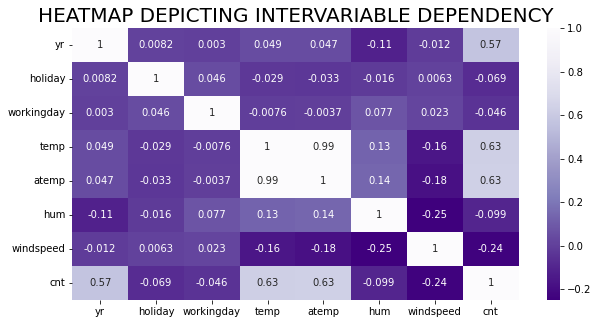

In [78]:
# Defining figure size
plt.figure(figsize= (10, 5))

# Plotting heatmap
sns.heatmap(boombikes.corr(), annot= True, cmap = 'Purples_r')

# Adjusting labels and titles
plt.title('heatmap depicting intervariable dependency'.upper(), fontsize= 20)

plt.show()

#### Observations:
- Above heatmaps reconfirms our previous observations made from pairplot
- Extremly high correleation is observed between temp and atemp

## Analysis of Growth over Last Year

In [83]:
# Creating fresh dataframe showing monthly demand growth over last year
growth_df = boombikes.pivot_table(index= 'mnth', columns= 'yr', values= 'cnt', aggfunc= 'mean')

# Amending column names
growth_df.columns = ['2018', '2019']

# % growth column
growth_df['percent_growth'] = round(((growth_df['2019'] - growth_df['2018'])/growth_df['2018'])*100, 2)

# Sorting dataframe
growth_df = growth_df.sort_values(by= 'percent_growth', ascending= False)

# Observing the final results
growth_df

,2018,2019,percent_growth
mnth,,,
Mar,2065.96774,5318.54839,157.44000
Jan,1231.90323,3120.77419,153.33000
Feb,1721.96429,3617.96429,110.11000
Apr,3162.33333,5807.46667,83.64000
Sep,4247.26667,7285.76667,71.54000
Oct,3984.22581,6414.22581,60.99000
Aug,4409.38710,6919.45161,56.93000
Nov,3405.56667,5088.80000,49.43000
May,4381.32258,6318.22581,44.21000


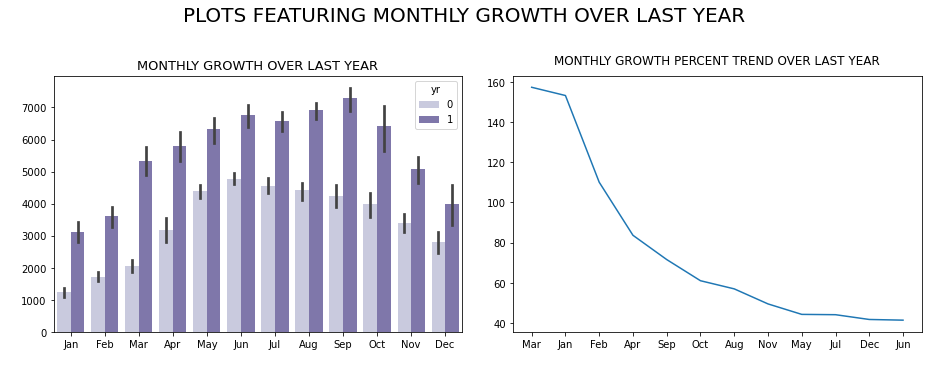

In [85]:
# Creating a subplot grid
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(13, 5))

# Creating main title
fig.suptitle('plots featuring monthly growth over last year'.upper(), fontsize=20, y=1.02)

# Populating plot1:
sns.barplot(x= 'mnth', y= 'cnt', data= boombikes, hue= 'yr', ax= ax[0], palette= 'Purples')
ax[0].set_title('monthly growth over last year'.upper(), fontsize= 13)
ax[0].set_ylabel(' ')
ax[0].set_xlabel(' ')

# Populating plot1:
sns.lineplot(x= growth_df.index, y= growth_df['percent_growth'], ax= ax[1], palette= 'Purples')
ax[1].set_title('monthly growth percent trend over last year'.upper(), fontsize= 12, fontweight= 20, y= 1.02)
ax[1].set_ylabel(' ')
ax[1].set_xlabel(' ')

# Setting aesthetics
plt.tight_layout()
plt.show()

#### Observations:
- Tremendous business growth shown in 2019 over 2018
- 100+% growth observed in the month of Jan, Feb, and March.

# Logic Note for further model development approach

#### Machine Learning Problem
- Relationship in target variable found with temp, atemp, humidity, and windspeed in pairplot
- Target variable found to be correlated with date, month, season as depicted in earlier plots.
- `Based on above, it is proven that this qualifies as Machine Learning problem since the outcome depends on independent features and historical records`

#### Supervised/Unsupervised
- We are provided with target variable and hence `it is a Supervised Learning problem`

#### Regression
- Given target variable (cnt) is continuous and hence, `this problem qualifies to be a regression problem`

#### Multiple Independent Features
- From given EDA, we now know that the target variable is dependent on multiple features. Hence, `this problem qualifies to be a Multiple Linear Regression problem`

# Using Multiple Linear Regression for Model Development

In [86]:
# Re-inspection of data
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,Jan,0,Mon,1,Misty and Cloudy,14.11085,18.18125,80.58330,10.74988,985
1,Spring,0,Jan,0,Tue,1,Misty and Cloudy,14.90260,17.68695,69.60870,16.65211,801
2,Spring,0,Jan,0,Wed,1,Clear to Partly Cloudy,8.05092,9.47025,43.72730,16.63670,1349
3,Spring,0,Jan,0,Thu,1,Clear to Partly Cloudy,8.20000,10.60610,59.04350,10.73983,1562
4,Spring,0,Jan,0,Fri,1,Clear to Partly Cloudy,9.30524,11.46350,43.69570,12.52230,1600


#### Observations:
- yr, holiday, and workingday are binary variables

## Creating Dummy Variables

In [87]:
# Creating new dataframe for ML algorithm (Deep copy of boombikes)
boombikes_ml = boombikes.copy()

In [88]:
# Creating a list of features that need to be converted to dummy variable
dummy_list= [i for i in boombikes_ml.select_dtypes(include= 'object').columns]

# Creating dummies
for i in dummy_list:
    dummy = pd.get_dummies(data= boombikes_ml[i], drop_first= True)
    boombikes_ml = pd.concat([boombikes_ml, dummy], axis= 1).drop(labels= i, axis= 1)

In [89]:
# Reinspecting dataframe
boombikes_ml.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain or Snow,Misty and Cloudy
0,0,0,1,14.11085,18.18125,80.58330,10.74988,985,1,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.90260,17.68695,69.60870,16.65211,801,1,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.05092,9.47025,43.72730,16.63670,1349,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.20000,10.60610,59.04350,10.73983,1562,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.30524,11.46350,43.69570,12.52230,1600,1,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
print(f'Post dummy creation, the dataset contains {boombikes_ml.shape[0]} rows and {boombikes_ml.shape[1]} columns.')

Post dummy creation, the dataset contains 730 rows and 30 columns.


## Intervariable Interactions

### Heatmap

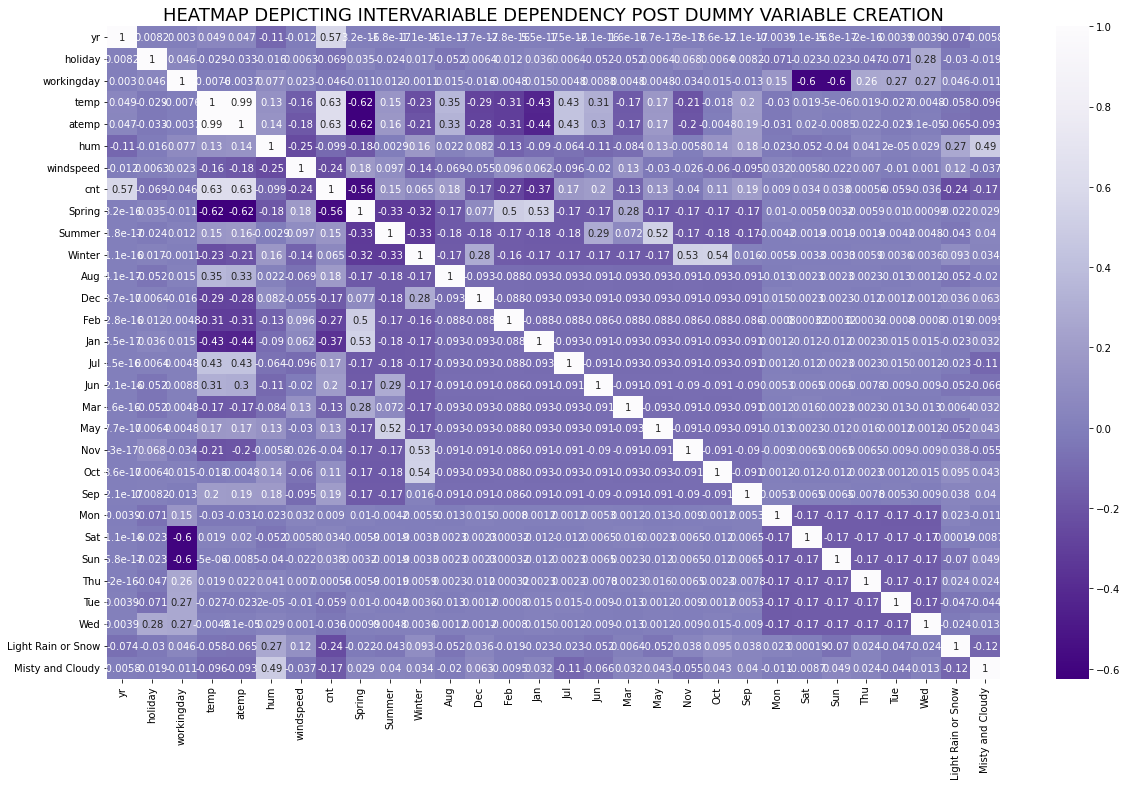

In [91]:
# Defining figure size
plt.figure(figsize= (20, 12))

# Plotting heatmap
sns.heatmap(boombikes_ml.corr(), annot= True, cmap = 'Purples_r', fmt= '.2g')

# Adjusting labels and titles
plt.title('heatmap depicting intervariable dependency post dummy variable creation'.upper(), fontsize= 18, y= 1)

plt.show()

#### Note:
- Heatmap has become very dense due to high number of variables and limitation of display space
- We will depict high number of positive and negative correlation in following dataframe.

### Dataframe hilighting Intervariable Relationships

In [102]:
# Initiating Variables
col_list = []
ind_list = []
corr_type = []
corr_strength = []
corr_list = []

# Developing loop
for i in range(len(boombikes_ml.corr().columns)):
    for j in range(len(boombikes_ml.corr().index)):
        if boombikes_ml.corr().columns[i] != boombikes_ml.corr().index[j] and boombikes_ml.corr().iloc[i, j] != 0:
            if boombikes_ml.corr().iloc[i, j] < 0:
                
                if boombikes_ml.corr().iloc[i, j] <= -0.7:
                    col_list.append(boombikes_ml.corr().columns[i])
                    ind_list.append(boombikes_ml.corr().index[j])
                    corr_type.append('Negative')
                    corr_strength.append('Strong')
                    corr_list.append(round(boombikes_ml.corr().iloc[i,j], 2))

                elif boombikes_ml.corr().iloc[i, j] < -0.3:
                    col_list.append(boombikes_ml.corr().columns[i])
                    ind_list.append(boombikes_ml.corr().index[j])
                    corr_type.append('Negative')
                    corr_strength.append('Medium')
                    corr_list.append(round(boombikes_ml.corr().iloc[i,j], 2))
            
            else:
                
                if boombikes_ml.corr().iloc[i, j] >= 0.7:
                    col_list.append(boombikes_ml.corr().columns[i])
                    ind_list.append(boombikes_ml.corr().index[j])
                    corr_type.append('Positive')
                    corr_strength.append('Strong')
                    corr_list.append(round(boombikes_ml.corr().iloc[i,j], 2))

                elif boombikes_ml.corr().iloc[i, j] >0.3:
                    col_list.append(boombikes_ml.corr().columns[i])
                    ind_list.append(boombikes_ml.corr().index[j])
                    corr_type.append('Positive')
                    corr_strength.append('Strong')
                    corr_list.append(round(boombikes_ml.corr().iloc[i,j], 2))

In [103]:
# New dataframe initiated to show intervariable relationships

boombike_corr_df = pd.DataFrame({
    'Column1': col_list,
    'Column2': ind_list,
    'Relationship Strength': corr_strength,
    'Relation Type': corr_type,
    'Correlation C': corr_list
})

# Inspecting the dataframe
boombike_corr_df

,Column1,Column2,Relationship Strength,Relation Type,Correlation C
0,yr,cnt,Strong,Positive,0.57000
1,workingday,Sat,Medium,Negative,-0.60000
2,workingday,Sun,Medium,Negative,-0.60000
3,temp,atemp,Strong,Positive,0.99000
4,temp,cnt,Strong,Positive,0.63000
5,temp,Spring,Medium,Negative,-0.62000
6,temp,Aug,Strong,Positive,0.35000
7,temp,Feb,Medium,Negative,-0.31000
8,temp,Jan,Medium,Negative,-0.43000
9,temp,Jul,Strong,Positive,0.43000


#### Observations:
- Above table clearly shows the correlation where the variables are correlated

#### NOTE:
- The degree and the strength of association was taken as:
    - If correlation is between 0.3 to 0.7: Strong Positive Correlation
    - If correlation is > 0.7: Strong Positive Correlation
    - If correlation is between -0.3 to -0.7: Medium Negative Correlation
    - If correlation is < -0.7: Strong Negative Correlation

In [104]:
# Displaying feature combinations of strong positive correlation
boombike_corr_df[(boombike_corr_df['Relationship Strength'] == 'Strong') & (boombike_corr_df['Relation Type'] == 'Positive')].sort_values(by= 'Correlation C', ascending= False)

,Column1,Column2,Relationship Strength,Relation Type,Correlation C
11,atemp,temp,Strong,Positive,0.99000
3,temp,atemp,Strong,Positive,0.99000
21,cnt,temp,Strong,Positive,0.63000
4,temp,cnt,Strong,Positive,0.63000
12,atemp,cnt,Strong,Positive,0.63000
22,cnt,atemp,Strong,Positive,0.63000
0,yr,cnt,Strong,Positive,0.57000
20,cnt,yr,Strong,Positive,0.57000
54,Oct,Winter,Strong,Positive,0.54000
38,Winter,Oct,Strong,Positive,0.54000


#### Observations:
- Total 32 pairs found with strong positive correlation
- Since each pair is repeated twice, effectively we have 16 pairs of variables that show strong correlation

In [105]:
# Displaying feature combinations of strong negative correlation
boombike_corr_df[(boombike_corr_df['Relationship Strength'] == 'Strong') & (boombike_corr_df['Relation Type'] == 'Negative')].sort_values(by= 'Correlation C', ascending= False)

,Column1,Column2,Relationship Strength,Relation Type,Correlation C


#### Observations:
- We do not have any variable pair that shows strong negative correlation

## Train Test Split

Divide the data in 2 distinct datasets:
- boombike_train: This dataset will be used in training the model to learn the coefficients
- boombike_test: This dataset will largely remain unknown to our model and will be used in the end to test the model's accuracy

In [106]:
boombikes_ml.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain or Snow,Misty and Cloudy
0,0,0,1,14.11085,18.18125,80.58330,10.74988,985,1,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.90260,17.68695,69.60870,16.65211,801,1,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.05092,9.47025,43.72730,16.63670,1349,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.20000,10.60610,59.04350,10.73983,1562,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.30524,11.46350,43.69570,12.52230,1600,1,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# Initialize boombike_train and boombike_test
boombike_train, boombike_test = train_test_split(boombikes_ml, test_size= 0.30, random_state= 100)

In [108]:
print(f'Training set: {boombike_train.shape}')
print(f'Test set: {boombike_test.shape}')

Training set: (511, 30)
Test set: (219, 30)


In [109]:
boombike_train.sample(5)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain or Snow,Misty and Cloudy
274,0,0,1,14.62335,17.26585,79.16670,14.87487,2918,0,0,...,1,0,0,0,0,0,1,0,0,1
136,0,0,1,23.02835,26.92645,83.79170,18.58272,4123,0,1,...,0,0,0,0,0,1,0,0,0,1
210,0,0,1,32.97085,36.42685,46.58330,11.29198,4475,0,0,...,0,0,1,0,0,0,0,0,0,0
486,1,0,1,23.13085,26.89480,79.70830,9.24989,6169,0,1,...,0,0,0,0,0,0,0,0,0,0
417,1,0,1,16.22915,19.63335,56.79170,15.70956,4773,1,0,...,0,0,0,0,0,0,0,0,0,0


## Rescaling of Data

#### We can choose from 2 of rescaling techniques:
- Normalization: Also, called MinMax Scaling. It compresses the features in the range between 0 and 1.
- Standarization: It moves data on plot in such a way that mean becomes 0 and standard deviation becomes 1.

#### In this case, we have decided to use MinMax Scaler because:
- As shown in previous section of EDA, some of the features contain outliers. We have not handled those outliers till now, and MinMaxScaler will automatically handle them.
- Distribution does not matter in our dataset
- Presence of binary variable which are already in 0 and 1 form. So rest of the data can be scaled accordingly.

MinMaxScaler uses Normalization formula $(X-Xmin)/(Xmax-Xmin)$ which basically translates the maximum data value as 1 and minimum data value as 0. Rest of the datapoints will remain between 1 and 0 based on relative context.

**Rescaling of data is done post the train_test_split because we do not want the scaler or final model to know about the test dataset**

### Applying MinMaxScaler based on above logic on train data

In [110]:
# Create a scaler instance
scaler = MinMaxScaler()

In [113]:
# Initializing a list of feature names for scaling
scaler_list = [i for i in boombike_train.columns if boombike_train[i].nunique() > 2]

# Scaling the variables and saving in our dataframe
boombike_train[scaler_list] = scaler.fit_transform(boombike_train[scaler_list])

In [114]:
# Inspecting boombike_train
boombike_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain or Snow,Misty and Cloudy
653,1,0,1,0.50989,0.50113,0.57535,0.30079,0.86424,0,0,...,1,0,0,0,0,1,0,0,0,0
576,1,0,1,0.81517,0.76635,0.72563,0.26469,0.82766,0,0,...,0,0,0,0,0,1,0,0,0,0
426,1,0,1,0.44239,0.43897,0.64019,0.25534,0.46526,1,0,...,0,0,1,0,0,0,0,0,0,1
728,1,0,1,0.24510,0.20035,0.49807,0.66311,0.20410,1,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,1,0.39567,0.39174,0.50451,0.18847,0.48297,0,1,...,0,0,1,0,0,0,0,0,0,1


## Splitting Training Dataset in X and y

In [115]:
# Splitting in X and y
y_train = boombike_train.pop('cnt')
X_train = boombike_train

In [116]:
# Inspecting shapes of X_train and y_train
print(f'X_train shape: {X_train.shape}, y_train_shape: {y_train.shape}')

X_train shape: (511, 29), y_train_shape: (511,)


# Model Development

We have decided to use combination of automated feature selection:
- **Automated Selection:** During the initial stage, we will use RFE (Recursive Feature Elimination) for automated feature selection.
- **Manual Selection:** Post automated approach, we will fine tune the feature selection using manual approach based on knowledge gained.

## Recursive Feature Elimination (RFE)

In [117]:
# Creating an instance of Linear Regression
lm = LinearRegression()

# Fitting model with X_train and y_train
lm.fit(X_train, y_train)

# Creating RFE instance on fitted lm
rfe = RFE(lm, 15)

# Converting rfe to fitted rfe
rfe = rfe.fit(X_train, y_train)

In [118]:
# Brief visual observation of results
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 10),
 ('temp', True, 1),
 ('atemp', False, 4),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Aug', False, 6),
 ('Dec', False, 2),
 ('Feb', False, 3),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 14),
 ('Mar', False, 15),
 ('May', False, 5),
 ('Nov', True, 1),
 ('Oct', False, 12),
 ('Sep', True, 1),
 ('Mon', False, 13),
 ('Sat', False, 11),
 ('Sun', False, 9),
 ('Thu', False, 8),
 ('Tue', True, 1),
 ('Wed', False, 7),
 ('Light Rain or Snow', True, 1),
 ('Misty and Cloudy', True, 1)]

#### Observations:
- Above results show the suggestions given by RFE function to retain top 15 features
- According to the industrial preffered practice of taking half the variable in account while operating RFE function, we have chosen 15 features to retain
- Wherever the boolean returned by rfe.support_ is True, that feature is suggested by RFE to include in the model

#### Extract 15 most indexed columns in train dataset

In [119]:
# Initializing another dataframe
temp_rfe_df = pd.DataFrame()

# Adding names of features
temp_rfe_df['Col'] = X_train.columns

# Adding rfe.support_ to dataframe (Returns bool type value: True if feature is recommended to be kept and False otherwise)
temp_rfe_df['RFE_support'] = rfe.support_

# Retain only the values that are recommended to be included in the initial model
temp_rfe_df = temp_rfe_df[temp_rfe_df['RFE_support'] == True]

# Inspecting the dataframe
temp_rfe_df

,Col,RFE_support
0,yr,True
1,holiday,True
3,temp,True
5,hum,True
6,windspeed,True
7,Spring,True
8,Summer,True
9,Winter,True
13,Jan,True
14,Jul,True


In [121]:
# Initializing a list of features that are to be included in initial model signalled by above dataframe
cols = [i for i in temp_rfe_df['Col']]

# Retaining features that are recommended in X_train
X_train[cols].head()

,yr,holiday,temp,hum,windspeed,Spring,Summer,Winter,Jan,Jul,Nov,Sep,Tue,Light Rain or Snow,Misty and Cloudy
653,1,0,0.50989,0.57535,0.30079,0,0,1,0,0,0,0,0,0,0
576,1,0,0.81517,0.72563,0.26469,0,0,0,0,1,0,0,0,0,0
426,1,0,0.44239,0.64019,0.25534,1,0,0,0,0,0,0,0,0,1
728,1,0,0.24510,0.49807,0.66311,1,0,0,0,0,0,0,1,0,0
482,1,0,0.39567,0.50451,0.18847,0,1,0,0,0,0,0,0,0,1


In [122]:
print(f'Final dataframe for model training has {X_train[cols].shape[0]} rows and {X_train[cols].shape[1]} columns')

Final dataframe for model training has 511 rows and 15 columns


## Model Development

**During model development stage:**

**Variance Influence Factor:** Also known as VIF, available in statsmodel library will be used to determine the variable that needs to be dropped to handle multicollinearity. `We will consider a threshold of 5 beyond which we will drop those variables (unless any logic forces us to believe in keeping those particular variables in the data set)`

**Ordinary Least Squares:** We will use statsmodel to develop the Linear Regression Model using OLS (Ordinary Least Squares) method. It is available in statsmodel library and aims to minimize sum of residual squares to determine most ideal regression line. `We will consider a threshold of 0.05 p-value beyond which we will drop those variables one by one (unless any logic forces us to believe in keeping those particular variables in the data set)`

**During model development, we will start with all the variables calculating VIF for each of the variables and then building regression model using OLS. We will observe a combination of VIF values and p-values generated by the OLS model and drop the insignificant variables one by one. With each variable being dropped, an increase in R-squared is being expected and p-values of leftover variables is expected to reduce and finally we will be left with all significant variables and a workable model.**

### Defining Functions

In [129]:
# Defining function for VIF table
def vif_table(dataframe):
    # Initialize a dataframe
    vif = pd.DataFrame()
    
    # Adding feature names
    vif['Feature'] = dataframe.columns
    
    # Adding feature VIF values
    vif['VIF Value'] = [round(variance_inflation_factor(dataframe.values, i), 2) for i in range(len(dataframe.columns))]
    
    # Sorting dataframe
    vif = vif.sort_values(by= 'VIF Value', ascending= False)
    
    return vif

In [124]:
# Defining function for regression statistics
def regmodel_ols(y_dataframe, X_dataframe):
    # Adding constant - statsmodel needs a constant to be explicitly added
    X_dataframe = sm.add_constant(X_dataframe)
    
    # Creating a linear regression instance based on OLS and fitting the data and creating summary
    lm = sm.OLS(y_dataframe, X_dataframe).fit()
    
    # Printing statistical summary
    print(lm.summary())

In [125]:
# Initiating dataframe
X_train_1 = X_train[cols]

### Building Model

In [127]:
# Building Regression Model
regmodel_ols(y_train, X_train_1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     185.1
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          7.37e-192
Time:                        15:46:49   Log-Likelihood:                 520.79
No. Observations:                 511   AIC:                            -1010.
Df Residuals:                     495   BIC:                            -941.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3050      0

#### Observations:
- Above model shows R-sqaured value of 0.849(~85% variance in target variable is explained by the given 15 variables)
- Adjusted R-squared is 0.844
- P-Value of all variables are within the acceptable threshold of 0.05 except for November. So, we will drop this feature in the next model.
- It is important to keep the model simple and less complicated while maintaining efficacy and hence it is advisable to reduce the number of features.


In [130]:
# Inspecting VIF values
vif_table(X_train_1)

,Feature,VIF Value
3,hum,29.35000
2,temp,16.83000
4,windspeed,4.73000
5,Spring,4.37000
7,Winter,3.79000
6,Summer,2.80000
14,Misty and Cloudy,2.31000
0,yr,2.09000
8,Jan,1.67000
9,Jul,1.59000


#### Observations:
- VIF of hum and temp is very high and not in acceptable limits

In [132]:
# Dropping 'Nov' column
X_train_2 = X_train_1.drop(labels= 'Nov', axis= 1)

# Rebuilding the model
regmodel_ols(y_train, X_train_2)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     197.7
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.55e-192
Time:                        16:04:37   Log-Likelihood:                 519.65
No. Observations:                 511   AIC:                            -1009.
Df Residuals:                     496   BIC:                            -945.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2977      0

#### Observations:
- Above model shows R-sqaured value of 0.848(84.8% variance in target variable is explained by the given 14 variables)
- Adjusted R-squared is 0.844
- P-Value of all variables are within the acceptable threshold of 0.05. So, we cannot decide based on p-values which feature has to be dropped next.

In [134]:
# Inspecting VIF values
vif_table(X_train_2)

,Feature,VIF Value
3,hum,29.28000
2,temp,16.74000
4,windspeed,4.67000
5,Spring,4.34000
7,Winter,3.38000
6,Summer,2.79000
13,Misty and Cloudy,2.30000
0,yr,2.09000
8,Jan,1.67000
9,Jul,1.59000


#### Observations:
- VIF of hum and temp is very high and not in acceptable limits
- P-Value of all variables are within the acceptable threshold of 0.05. So, we cannot decide based on p-values which feature has to be dropped next.
- Both these variables are significant and their removal will affect the R-squared and Adjusted R-Squared values negatively. Let's drop `hum` column before we redevelop the model.

In [138]:
# Dropping 'hum' column
X_train_3 = X_train_2.drop(labels= 'hum', axis= 1)

# Rebuilding the model
regmodel_ols(y_train, X_train_3)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     204.5
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          7.11e-190
Time:                        16:15:44   Log-Likelihood:                 510.53
No. Observations:                 511   AIC:                            -993.1
Df Residuals:                     497   BIC:                            -933.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2217      0

#### Observations:
- R squared and Adjusted R Squared values have shown substantial decline, however, our VIF values are probably within limits making our model valid.

In [139]:
# Inspecting VIF values
vif_table(X_train_3)

,Feature,VIF Value
2,temp,5.19000
3,windspeed,4.62000
4,Spring,2.78000
5,Summer,2.24000
0,yr,2.08000
6,Winter,1.82000
7,Jan,1.61000
8,Jul,1.59000
12,Misty and Cloudy,1.57000
9,Sep,1.34000


#### Observations:
- Value of `temp` is still beyond the acceptable limits to accept the model as valid. It shows high collinearity making model invalid.
- On closer inspection, we found that feature `Summer`, if dropped does not have strong impact on our R-squared values whereas dropping `temp` will significantly affect our R squared score.
- Dropping `Summer` feature

In [140]:
# Dropping 'summer' column
X_train_4 = X_train_3.drop(labels= 'Summer', axis= 1)

# Rebuilding the model
regmodel_ols(y_train, X_train_3)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     204.5
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          7.11e-190
Time:                        16:55:46   Log-Likelihood:                 510.53
No. Observations:                 511   AIC:                            -993.1
Df Residuals:                     497   BIC:                            -933.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2217      0

#### Observations:
- Impact on R squared and Adjusted R squared scores is minimal.

In [141]:
# Inspecting VIF values
vif_table(X_train_4)

,Feature,VIF Value
2,temp,4.70000
3,windspeed,4.02000
4,Spring,2.26000
0,yr,2.07000
6,Jan,1.60000
11,Misty and Cloudy,1.53000
5,Winter,1.41000
7,Jul,1.36000
8,Sep,1.20000
9,Tue,1.18000


#### Observations:
- All features are now within acceptable limits of VIF value.
- We still have 12 variables making it very complex.

In [142]:
# Dropping 'Tue' column
X_train_5 = X_train_4.drop(labels= 'Tue', axis= 1)

# Rebuilding the model
regmodel_ols(y_train, X_train_5)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     228.1
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.22e-186
Time:                        17:03:41   Log-Likelihood:                 497.23
No. Observations:                 511   AIC:                            -970.5
Df Residuals:                     499   BIC:                            -919.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2665      0

In [143]:
# Inspecting VIF values
vif_table(X_train_5)

,Feature,VIF Value
2,temp,4.64000
3,windspeed,4.01000
4,Spring,2.24000
0,yr,2.07000
6,Jan,1.60000
10,Misty and Cloudy,1.53000
5,Winter,1.39000
7,Jul,1.36000
8,Sep,1.20000
9,Light Rain or Snow,1.08000


#### Observations:
- Note the impact on R squared and Adjusted R Squared has been extremely minute but the model has become slightly simpler with reduction of variables.
- Dropping `Jan` feature

In [146]:
# Dropping 'Jan' column
X_train_6 = X_train_5.drop(labels= 'Jan', axis= 1)

# Rebuilding the model
regmodel_ols(y_train, X_train_6)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.0
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.28e-186
Time:                        17:06:51   Log-Likelihood:                 494.32
No. Observations:                 511   AIC:                            -966.6
Df Residuals:                     500   BIC:                            -920.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2526      0

#### Observations:
- Slight impact on R squared and Adjusted R squared but model has become simpler with 10 variables.

In [147]:
# Inspecting VIF values
vif_table(X_train_6)

,Feature,VIF Value
2,temp,4.61000
3,windspeed,4.00000
0,yr,2.06000
4,Spring,1.64000
9,Misty and Cloudy,1.52000
5,Winter,1.39000
6,Jul,1.35000
7,Sep,1.20000
8,Light Rain or Snow,1.08000
1,holiday,1.04000


#### Observations:
- All VIF values are in proper limit thus fulfilling the `assumption of Multicollinearity` and making our model valid.

**As shown above, one of the assumptions of Linear Regression is satisfied:**

-**`None of the features in our model are related to one or combination of more than one features`**

# Residual Analysis

## Normal Distribution of Errors

In [148]:
lm = sm.OLS(y_train, X_train_6).fit()
y_train_pred = lm.predict(X_train_6)
residuals = y_train - y_train_pred

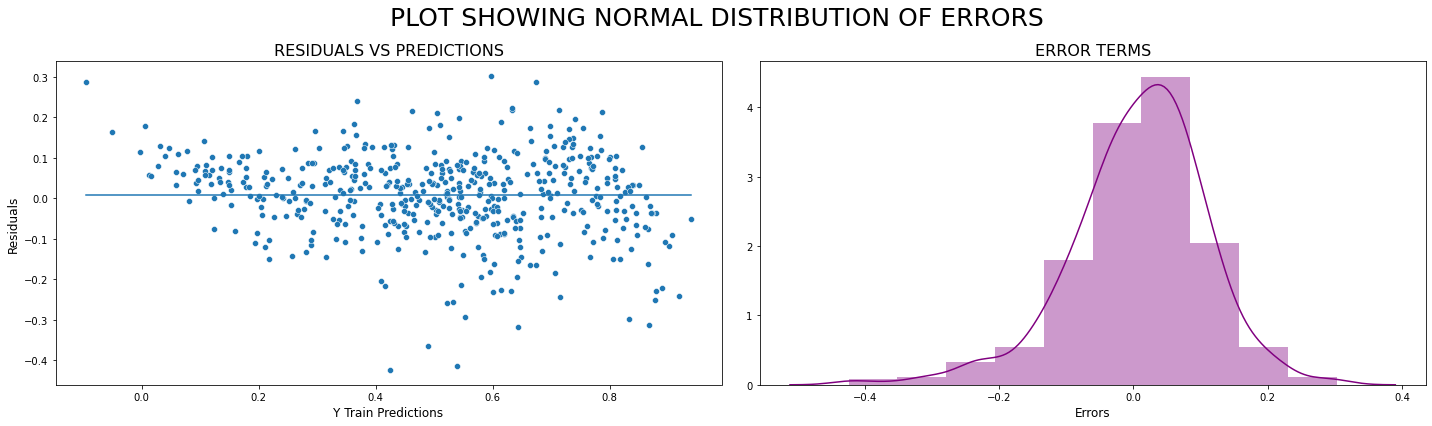

In [149]:
# Creating a subplot grid
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(20, 6))

# Creating main title
fig.suptitle('plot showing normal distribution of errors'.upper(), fontsize=25)

# Populating plot1:
sns.scatterplot(y= residuals.values, x= y_train_pred.values, ax= ax[0], palette= 'Purples')
sns.lineplot(y= residuals.mean(), x= y_train_pred.values, ax= ax[0], palette= 'Purples')
ax[0].set_title('residuals vs predictions'.upper(), fontsize= 16)
ax[0].set_ylabel('residuals'.title(), fontsize= 12)
ax[0].set_xlabel('y train predictions'.title(), fontsize= 12)

# Populating plot1:
sns.distplot(residuals, bins= 10, ax= ax[1], color= 'purple')
ax[1].set_title('error terms'.upper(), fontsize= 16)
ax[1].set_ylabel(' ')
ax[1].set_xlabel('errors'.title(), fontsize= 12)

# Setting aesthetics
plt.tight_layout()
plt.show()

#### Observations:
- Mean of the residuals is extremely close to 0.
- For smaller values of predictions, the residuals are found to be on the higher side and focused above the mean value of 0.
- This validates our assumption of normal distribution errors around 0

## Testing for Homoscedasticity

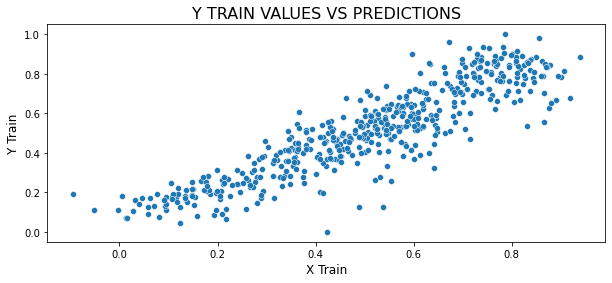

In [150]:
# Initiating a variable to save series containing residuals
residuals = y_train - y_train_pred

# Plotting residuals against predicted values

# Defining the figure dimension
plt.figure(figsize= (10, 4))

# Plotting the residuals
sns.scatterplot(y= y_train, x= y_train_pred, palette= 'Purples')

# Setting title, ylabel, and xlabel
plt.title('y train values vs predictions'.upper(), fontsize= 16)
plt.ylabel('y train'.title(), fontsize= 12)
plt.xlabel('x train'.title(), fontsize= 12)

plt.show()

#### Observations:
- The plot shows an almost constant variance of predictions and thus the errors validating the assumptions of homoscedasticity

## Testing for correlation between Error Terms

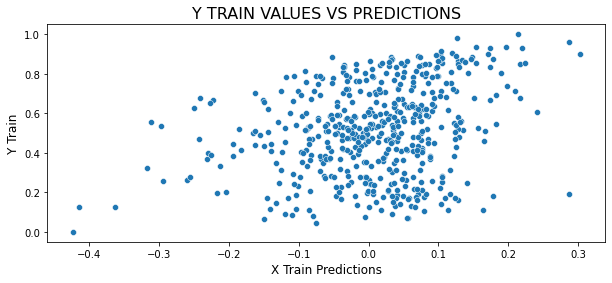

In [151]:
# Initiating a variable to save series containing residuals
residuals = y_train - y_train_pred

# Plotting residuals against predicted values

# Defining Figure Dimensions
plt.figure(figsize= (10, 4))

# Plotting the residuals
sns.scatterplot(y= y_train, x= residuals, palette= 'Purples')

# Setting title, ylabel, and xlabel
plt.title('y train values vs predictions'.upper(), fontsize= 16)
plt.ylabel('y train'.title(), fontsize= 12)
plt.xlabel('x train predictions'.title(), fontsize= 12)

plt.show()

#### Observations:
- There are no correlations between error terms. Hence, one more assumption of linear regression has been proved.

## Making Predictions

### Applying Scaling on Test Dataset

Our scaler instance of MinMaxScaler is already initiated. We shall use the same scaler to rescale our test data variables. The scaled feature names are stored in the variable scaler_list from rescaling activity of train set. We shall use the same to scale test data.

In [152]:
# Inspecting test data before scaling
boombike_test.sample(5)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain or Snow,Misty and Cloudy
522,1,0,0,24.70250,28.47210,56.70830,10.54245,7494,0,1,...,0,0,0,1,0,0,0,0,0,0
42,0,0,1,9.12250,11.64770,54.41670,13.62559,1472,1,0,...,0,0,1,0,0,0,0,0,0,0
682,1,0,1,11.85585,14.07815,55.20830,13.37487,5495,0,0,...,0,0,0,0,0,0,0,0,0,0
572,1,0,0,32.04835,36.71085,59.45830,10.25046,6904,0,0,...,0,0,0,0,1,0,0,0,0,0
213,0,0,1,32.11665,35.35355,49.12500,13.79195,4845,0,0,...,0,0,0,0,0,1,0,0,0,0


In [153]:
# Scaling the variables and saving in our dataframe:
boombike_test[scaler_list] = scaler.transform(boombike_test[scaler_list])

**NOTE:**

- scaler is already fitted on the train dataset, hence, in this step we did not use `fit()` or `fit_transform()` and just used `transform()` method.

In [154]:
# Inspecting test data post scaling
boombike_test.sample(5)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain or Snow,Misty and Cloudy
22,0,0,1,0.04659,0.02595,0.44983,0.43920,0.11091,1,0,...,0,0,0,0,0,0,1,0,0,0
522,1,0,0,0.67707,0.64368,0.58437,0.24733,0.85964,0,1,...,0,0,0,1,0,0,0,0,0,0
589,1,0,1,0.82451,0.76551,0.56204,0.20188,0.78935,0,0,...,0,0,0,0,0,0,0,1,0,0
411,1,0,0,0.32090,0.32959,0.77587,0.10560,0.34319,1,0,...,0,0,0,1,0,0,0,0,0,1
721,1,0,0,0.23264,0.23680,0.53113,0.19516,0.20306,1,0,...,0,0,0,0,0,0,1,0,0,0


### Partitioning the data into X_Test and y_Test

In [155]:
y_test = boombike_test.pop('cnt')
X_test = boombike_test

In [156]:
# Inspecting the X_test
X_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,Spring,Summer,Winter,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain or Snow,Misty and Cloudy
184,0,1,1,0.83178,0.76966,0.65736,0.08422,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,0.90135,0.84259,0.61013,0.15373,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,0,0.51196,0.49615,0.83770,0.33421,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,0.88163,0.79534,0.43710,0.33957,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0.81725,0.74147,0.31430,0.53741,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [157]:
# Inspecting the test set shape:
print(f'X_test shape is: {X_test.shape}')
print(f'y_test shape is: {y_test.shape}')

X_test shape is: (219, 29)
y_test shape is: (219,)


### Making Actual Predictions

In [158]:
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_6.columns]

In [159]:
# Making predictions
y_test_pred = lm.predict(X_test_new)

## Evaluating the Predictions

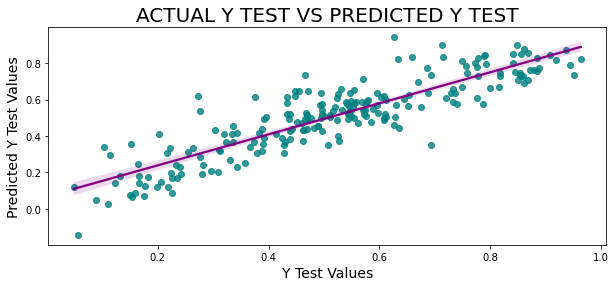

In [160]:
# Plotting the y_test and y_pred to understand the spread

# Defining Figure Dimensions
plt.figure(figsize= (10, 4))

# Plotting the residuals
sns.regplot(y= y_test_pred, x= y_test, scatter_kws={'color': 'teal'}, line_kws={'color': 'purple'})

# Setting title, ylabel, and xlabel
plt.title('actual y test vs predicted y test'.upper(), fontsize= 20)
plt.ylabel('predicted y test values'.title(), fontsize= 14)
plt.xlabel('y test values'.title(), fontsize= 14)

plt.show()

 #### Observations:
 - Y Test values and Y Test Predicted values have shown a strong visual semblence and hence our predictions are evaluated as a healthy fit. We do have presence of outliers, however, on a broader scale, most of the point display a healthy fit by following a tren.

### Assessing the Model Quality and Generalization Ability

In [163]:
print('R2 score of test data predictions:', round(r2_score(y_pred= y_test_pred, y_true= y_test), 5))
print('R2 score of train data predictions:', round(r2_score(y_pred= y_train_pred, y_true= y_train), 5))
print('Absolute difference between R2 scores of test and train dataset predictions:', abs(round(r2_score(y_pred= y_test_pred, y_true= y_test) - r2_score(y_pred= y_train_pred, y_true= y_train), 5)))

R2 score of test data predictions: 0.77369
R2 score of train data predictions: 0.79497
Absolute difference between R2 scores of test and train dataset predictions: 0.02129


**Since variation between train data prediction and test data prediction r2_score is less than 5%, model is proven to be dependable enough to be generalized.**

### Equation of Prediction

In [164]:
# Initaiting const variable for constant
const = 0.2526 # This information is taken from X_train_6 OLS Model above

# Parameters Series:
parameter_series = pd.Series(lm.params)
print(parameter_series)

yr                    0.24236
holiday              -0.09353
temp                  0.73126
windspeed            -0.02337
Spring                0.00276
Winter                0.12793
Jul                  -0.10141
Sep                   0.05428
Light Rain or Snow   -0.27750
Misty and Cloudy     -0.05975
dtype: float64


In [165]:
# Equation
print(f'Demand = {round(const, 3)}')
for i in range(len(parameter_series)):
    if i != len(parameter_series) - 1:
        print(f'\t{parameter_series.index[i]} x {round(parameter_series.values[i], 3)} +')
    else:
        print(f'\t{parameter_series.index[i]} x {round(parameter_series.values[i], 3)}')

Demand = 0.253
	yr x 0.242 +
	holiday x -0.094 +
	temp x 0.731 +
	windspeed x -0.023 +
	Spring x 0.003 +
	Winter x 0.128 +
	Jul x -0.101 +
	Sep x 0.054 +
	Light Rain or Snow x -0.278 +
	Misty and Cloudy x -0.06


**Demand** = 0.253 + (**Year** * 0.242) + (**Holiday** * -0.094) + (**Temperature** * 0.731) + (**Windspeed** * -0.023) + (**Spring** * 0.003) + (**Winter** * 0.128) + (**July** * -0.101) + (**September** * 0.054) + (**Light Rain or Snow** * -0.278) + (**Misty and Cloudy** * -0.06)

**Notes:**

- Coefficients of `Year`, `Temperature`, `Spring`, `Winter`, and `September` are positive.
- Coefficients of `Light Rain or Snow`, `Misty and Cloudy`, `Holiday`, `July`, and `Windspped` are negative.
- Constant is 0.253. That is, if all variables are kept at 0, the demand will be 0.253.

#### Model Explanation:
- If all variables are kept at 0, the demand will be 0.253.
- Following logic conclusions can be derived from above equation if all external and internal variables are stable:
    - If other features remain unchanged, with every change of year, demand is expected to increase 0.242 units.
    - If other features remain unchanged, demand is expected to increase by 0.003 units in the months corresponding to Spring season.
    - If other features remain unchanged, demand is expected to increase by 0.128 units in the months corresponding to Winter season.
    - If other features remain unchanged, demand is expected to increase by 0.054 units in the September month.
    - If other features remain unchanged, demand is expected to decrease by 0.278 units on the day of Light Rain or Snow.
    - If other features remain unchanged, demand is expected to decrease by 0.06 units on the day of Mist or Cloud.
    - If other features remain unchanged, demand is expected to decrease by 0.094 units on the holidays.
    - If other features remain unchanged, demand is expected to decrease by 0.101 units in the month of July.
    - If other features remain unchanged, demand is expected to decrease by 0.278 units on the day of Light Rain or Snow.
    